In [1]:
import requests
import pandas as pd
import io
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# URL do dataset
url = 'https://data.brasil.io/dataset/covid19/caso_full.csv.gz'

response = requests.get(url)

# Descompacta o conteúdo e lê com pandas
with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as gz:
    df_base = pd.read_csv(gz)

# Exibe as primeiras linhas
df_base.head()


,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0,0,1,city,AC,3,0
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0,0,1,state,AC,3,0
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0,0,2,city,AC,0,0
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0,0,2,state,AC,0,0
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0,0,3,city,AC,1,0


In [26]:
df_base

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0000,0,1,city,AC,3,0
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0000,0,1,state,AC,3,0
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0000,0,2,city,AC,0,0
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0000,0,2,state,AC,0,0
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0000,0,3,city,AC,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853643,Tupirama,1721257.0,2022-03-27,202213,1922.0,1891.0,False,True,223,11602.49740,2021-12-08,0.0090,2,674,city,TO,0,0
3853644,Tupiratins,1721307.0,2022-03-27,202213,2729.0,2671.0,False,True,199,7292.04837,2021-12-08,0.0151,3,674,city,TO,0,0
3853645,Wanderlândia,1722081.0,2022-03-27,202213,11734.0,11683.0,False,True,1433,12212.37430,2021-12-08,0.0147,21,699,city,TO,0,0
3853646,Xambioá,1722107.0,2022-03-27,202213,11520.0,11540.0,False,True,2458,21336.80556,2021-12-08,0.0146,36,688,city,TO,0,0


In [3]:
df = df_base[
    ~df_base['city'].str.lower().str.strip().isin(['importados/indefinidos'])
].copy()


##### Análise da base

In [4]:
# Dataframes separador por estado e cidade

df_estado_nao_repete = df[(df["is_repeated"] == False) & (df['place_type'] == 'state')]
df_estado_ultimo = df[(df["is_last"] == True) & (df['place_type'] == 'state')]

df_cidade_nao_repete = df[(df["is_repeated"] == False) & (df['place_type'] != 'state')]
df_cidade_ultimo = df[(df["is_last"] == True) & (df['place_type'] != 'state')]

In [5]:
df.columns

Index(['city', 'city_ibge_code', 'date', 'epidemiological_week',
       'estimated_population', 'estimated_population_2019', 'is_last',
       'is_repeated', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'last_available_date',
       'last_available_death_rate', 'last_available_deaths', 'order_for_place',
       'place_type', 'state', 'new_confirmed', 'new_deaths'],
      dtype='object')

##### Contaminações

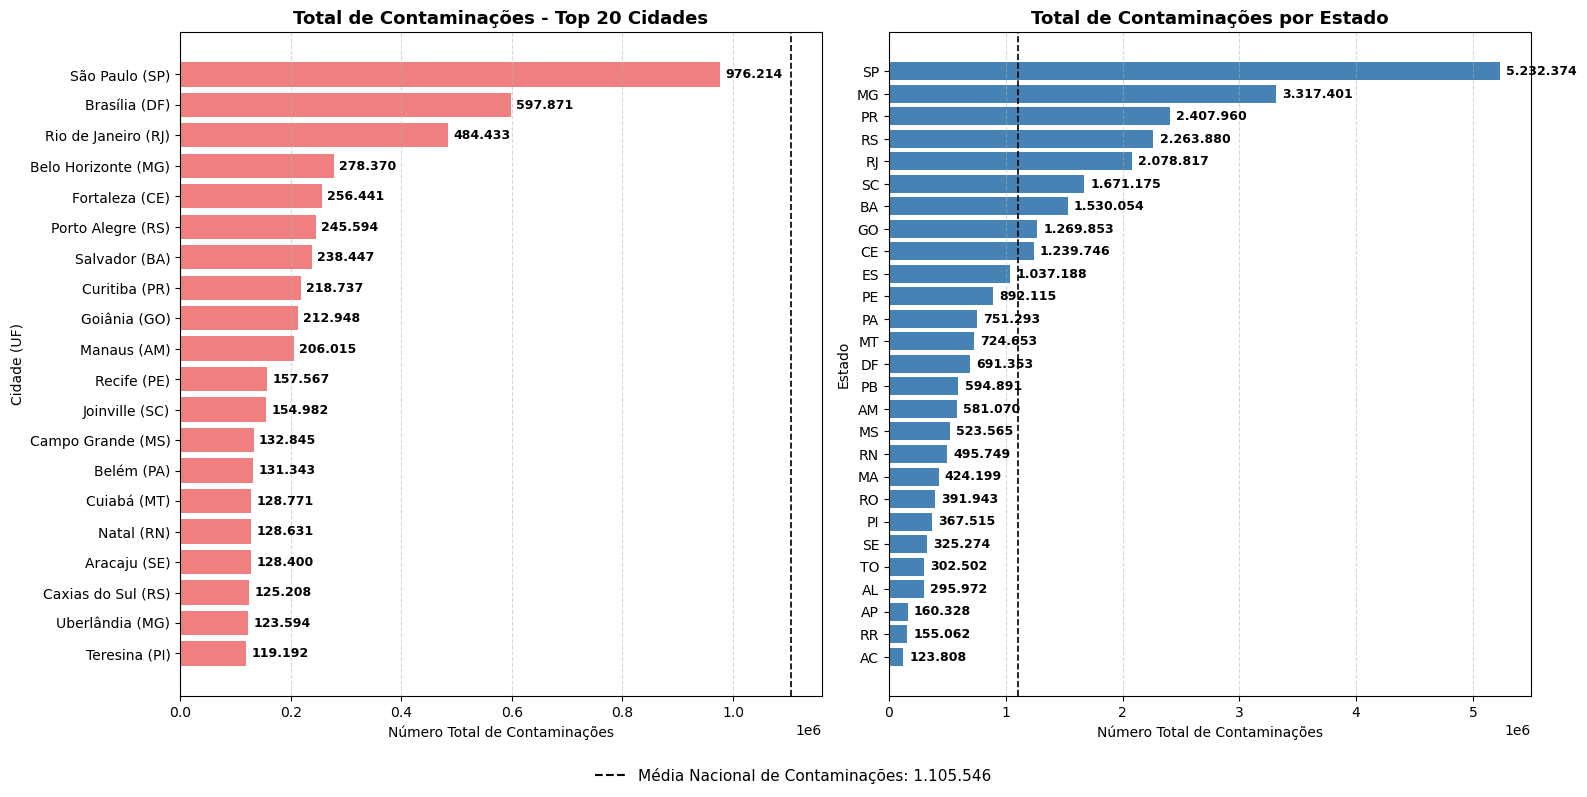

In [6]:
contaminacoes_por_estado = (
    df_estado_nao_repete.groupby('state')['last_available_confirmed']
    .max()
    .reset_index()
    .sort_values(by='last_available_confirmed', ascending=False)
)

contaminacoes_por_cidade = (
    df_cidade_ultimo.groupby(['state', 'city'])['last_available_confirmed']
    .max()
    .reset_index()
    .sort_values(by='last_available_confirmed', ascending=False)
    .head(20)
)

contaminacoes_por_cidade['cidade_estado'] = (
    contaminacoes_por_cidade['city'] + ' (' + contaminacoes_por_cidade['state'] + ')'
)

media_nacional_contaminacoes = contaminacoes_por_estado['last_available_confirmed'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(
    contaminacoes_por_cidade['cidade_estado'],
    contaminacoes_por_cidade['last_available_confirmed'],
    color='lightcoral',
    label='Cidades'
)
axes[0].set_title('Total de Contaminações - Top 20 Cidades', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Número Total de Contaminações')
axes[0].set_ylabel('Cidade (UF)')
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(contaminacoes_por_cidade['last_available_confirmed']):
    axes[0].text(v + (contaminacoes_por_cidade['last_available_confirmed'].max() * 0.01),
                 i, f'{int(v):,}'.replace(',', '.'),
                 va='center', fontsize=9, fontweight='bold')

axes[0].axvline(media_nacional_contaminacoes, color='black', linestyle='--', linewidth=1.2,
                label=f'Média Nacional: {media_nacional_contaminacoes:,.0f}'.replace(',', '.'))

axes[1].barh(
    contaminacoes_por_estado['state'],
    contaminacoes_por_estado['last_available_confirmed'],
    color='steelblue',
    label='Estados'
)
axes[1].set_title('Total de Contaminações por Estado', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Número Total de Contaminações')
axes[1].set_ylabel('Estado')
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(contaminacoes_por_estado['last_available_confirmed']):
    axes[1].text(v + (contaminacoes_por_estado['last_available_confirmed'].max() * 0.01),
                 i, f'{int(v):,}'.replace(',', '.'),
                 va='center', fontsize=9, fontweight='bold')

axes[1].axvline(media_nacional_contaminacoes, color='black', linestyle='--', linewidth=1.2)

fig.legend(
    loc='lower center',
    ncol=2,
    fontsize=11,
    frameon=False,
    handles=[
        plt.Line2D([0], [0], color='black', linestyle='--',
                   label=f'Média Nacional de Contaminações: {media_nacional_contaminacoes:,.0f}'.replace(',', '.'))
    ]
)

plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.show()

##### Mortes totais

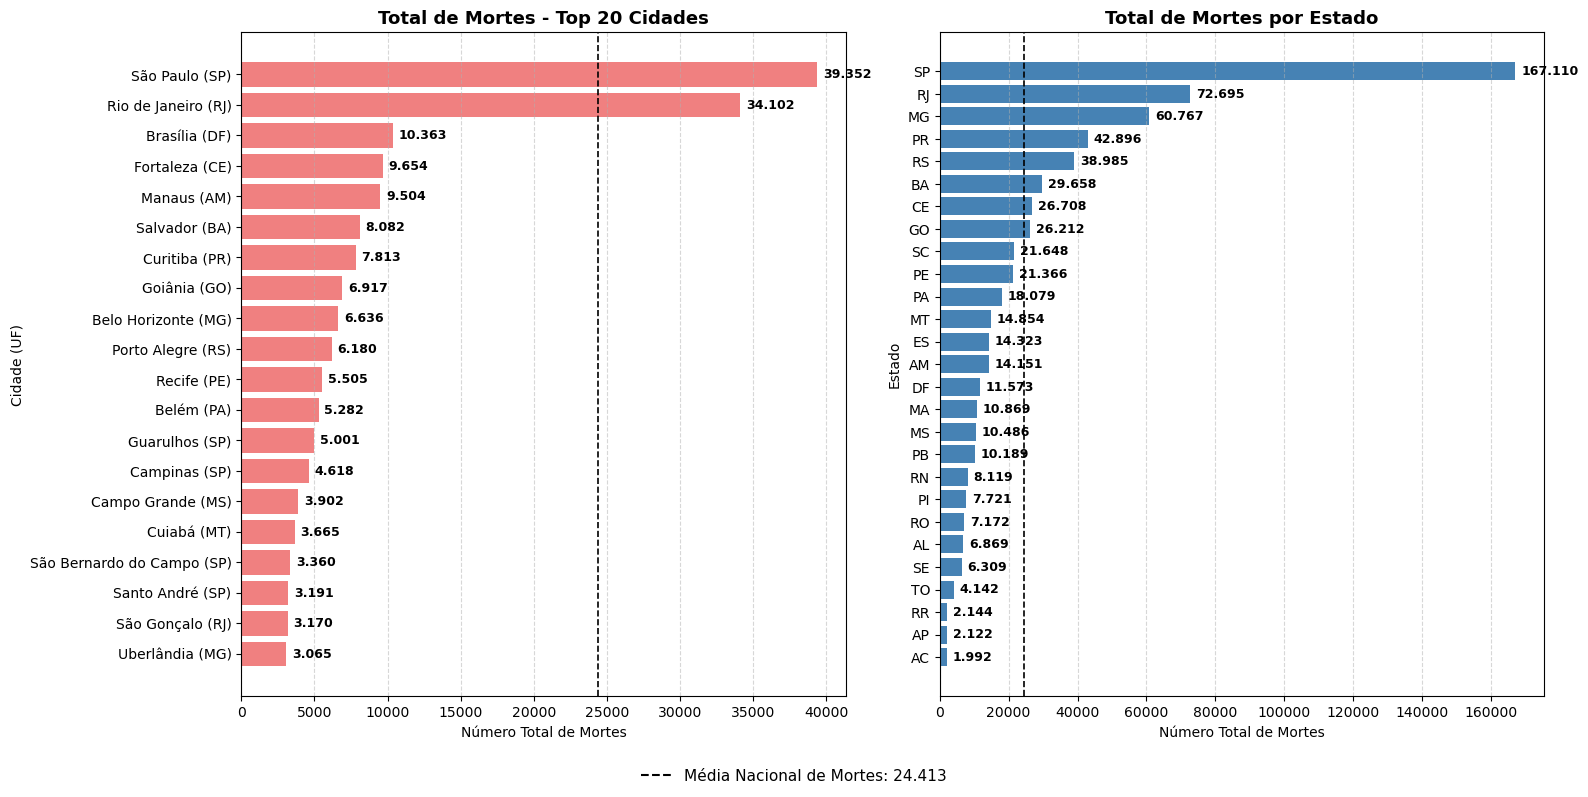

In [7]:
mortes_por_estado = (
    df_estado_nao_repete.groupby('state')['last_available_deaths']
    .max()
    .reset_index()
    .sort_values(by='last_available_deaths', ascending=False)
)

mortes_por_cidade = (
    df_cidade_ultimo.groupby(['state', 'city'])['last_available_deaths']
    .max()
    .reset_index()
    .sort_values(by='last_available_deaths', ascending=False)
    .head(20)
)

mortes_por_cidade['cidade_estado'] = (
    mortes_por_cidade['city'] + ' (' + mortes_por_cidade['state'] + ')'
)

media_nacional_mortes = mortes_por_estado['last_available_deaths'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(
    mortes_por_cidade['cidade_estado'],
    mortes_por_cidade['last_available_deaths'],
    color='lightcoral',
    label='Cidades'
)
axes[0].set_title('Total de Mortes - Top 20 Cidades', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Número Total de Mortes')
axes[0].set_ylabel('Cidade (UF)')
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(mortes_por_cidade['last_available_deaths']):
    axes[0].text(v + (mortes_por_cidade['last_available_deaths'].max() * 0.01),
                 i, f'{int(v):,}'.replace(',', '.'),
                 va='center', fontsize=9, fontweight='bold')

axes[0].axvline(media_nacional_mortes, color='black', linestyle='--', linewidth=1.2,
                label=f'Média Nacional: {media_nacional_mortes:,.0f}'.replace(',', '.'))

axes[1].barh(
    mortes_por_estado['state'],
    mortes_por_estado['last_available_deaths'],
    color='steelblue',
    label='Estados'
)
axes[1].set_title('Total de Mortes por Estado', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Número Total de Mortes')
axes[1].set_ylabel('Estado')
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(mortes_por_estado['last_available_deaths']):
    axes[1].text(v + (mortes_por_estado['last_available_deaths'].max() * 0.01),
                 i, f'{int(v):,}'.replace(',', '.'),
                 va='center', fontsize=9, fontweight='bold')

axes[1].axvline(media_nacional_mortes, color='black', linestyle='--', linewidth=1.2)

fig.legend(
    loc='lower center',
    ncol=2,
    fontsize=11,
    frameon=False,
    handles=[
        plt.Line2D([0], [0], color='black', linestyle='--',
                   label=f'Média Nacional de Mortes: {media_nacional_mortes:,.0f}'.replace(',', '.'))
    ]
)

plt.tight_layout(rect=[0, 0.05, 1, 1]) 
plt.show()

##### Média de mortes

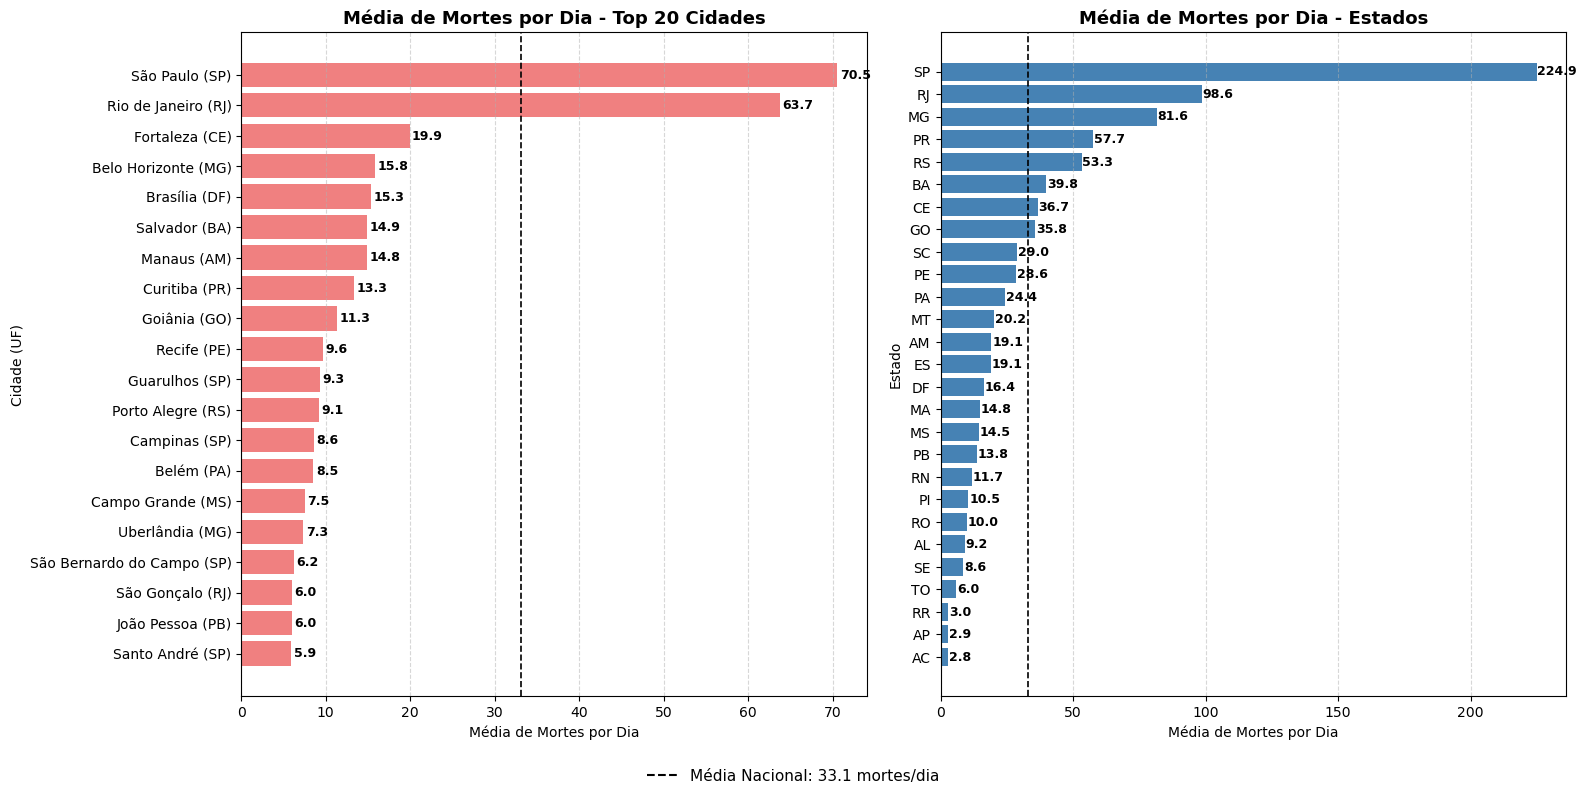

In [8]:
media_mortes_por_estado = (
    df_estado_nao_repete.groupby('state')['new_deaths']
    .mean()
    .reset_index()
    .sort_values(by='new_deaths', ascending=False)
)

media_mortes_por_cidade = (
    df_cidade_nao_repete.groupby(['state', 'city'])['new_deaths']
    .mean()
    .reset_index()
    .sort_values(by='new_deaths', ascending=False)
    .head(20)
)

media_mortes_por_cidade['cidade_estado'] = (
    media_mortes_por_cidade['city'] + ' (' + media_mortes_por_cidade['state'] + ')'
)

media_nacional = media_mortes_por_estado['new_deaths'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(
    media_mortes_por_cidade['cidade_estado'],
    media_mortes_por_cidade['new_deaths'],
    color='lightcoral',
    label='Cidades'
)

axes[0].set_title('Média de Mortes por Dia - Top 20 Cidades', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Média de Mortes por Dia')
axes[0].set_ylabel('Cidade (UF)')
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(media_mortes_por_cidade['new_deaths']):
    axes[0].text(v + 0.3, i, f'{v:.1f}', va='center', fontsize=9, fontweight='bold')

axes[0].axvline(media_nacional, color='black', linestyle='--', linewidth=1.2, label=f'Média Nacional: {media_nacional:.1f}')

axes[1].barh(
    media_mortes_por_estado['state'],
    media_mortes_por_estado['new_deaths'],
    color='steelblue',
    label='Estados'
)

axes[1].set_title('Média de Mortes por Dia - Estados', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Média de Mortes por Dia')
axes[1].set_ylabel('Estado')
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(media_mortes_por_estado['new_deaths']):
    axes[1].text(v + 0.3, i, f'{v:.1f}', va='center', fontsize=9, fontweight='bold')

axes[1].axvline(media_nacional, color='black', linestyle='--', linewidth=1.2)

fig.legend(
    loc='lower center',
    ncol=2,
    fontsize=11,
    frameon=False,
    handles=[
        plt.Line2D([0], [0], color='black', linestyle='--', label=f'Média Nacional: {media_nacional:.1f} mortes/dia')
    ]
)

plt.tight_layout(rect=[0, 0.05, 1, 1])


##### Taxa de mortalidade

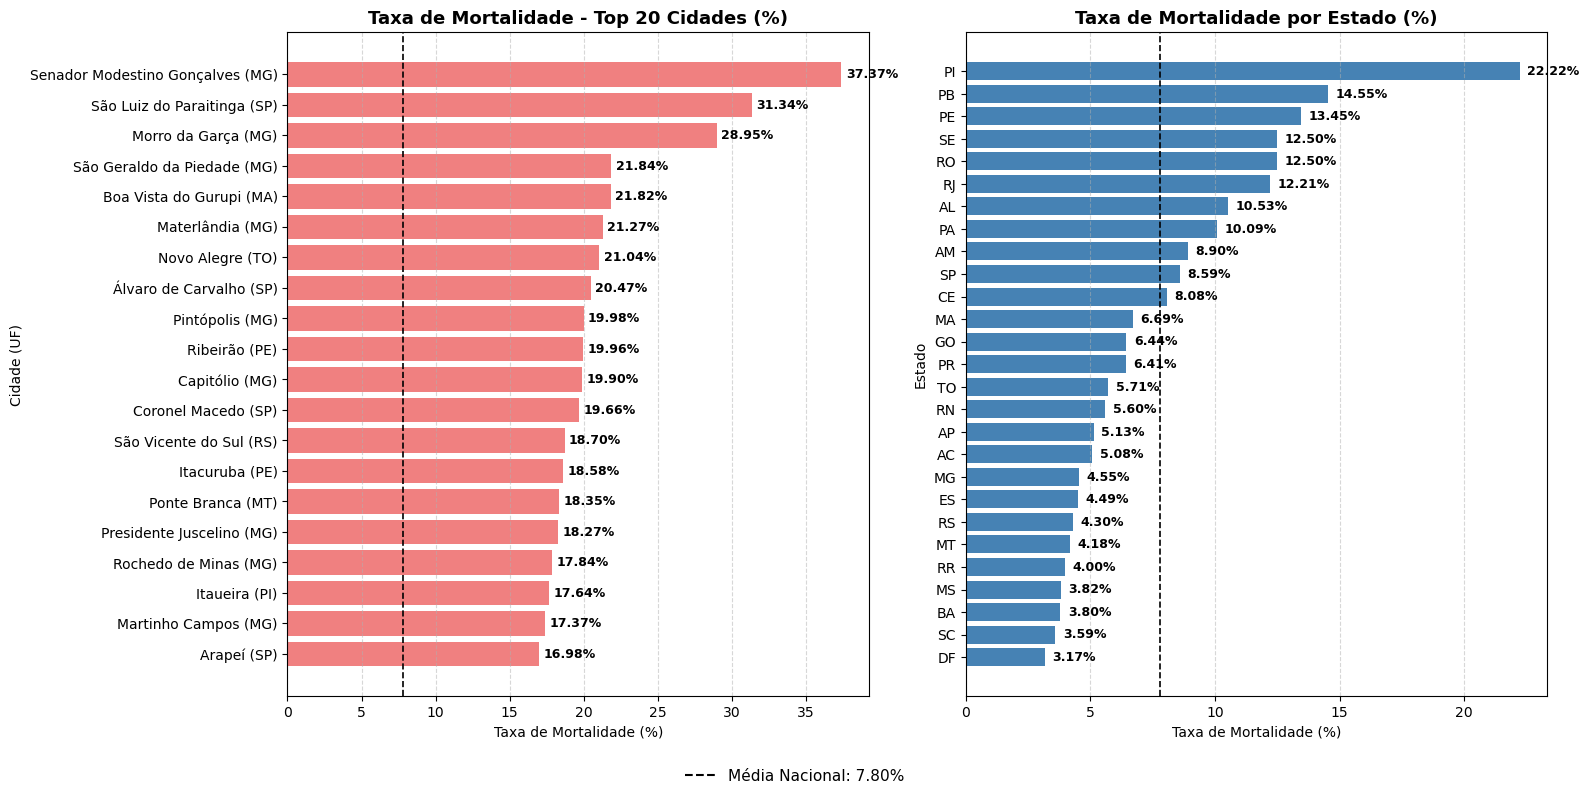

In [9]:
# Agrupar mantendo o estado como referência
taxa_mortalidade_por_cidade = (
    df_cidade_nao_repete
    .groupby(['state', 'city'])['last_available_death_rate']
    .mean()
    .reset_index()
    .sort_values(by='last_available_death_rate', ascending=False)
    .head(20)
)

taxa_mortalidade_por_estado = (
    df_estado_nao_repete.groupby('state')['last_available_death_rate']
    .max()
    .reset_index()
    .sort_values(by='last_available_death_rate', ascending=True)
)

taxa_mortalidade_por_cidade['taxa_percentual'] = (
    taxa_mortalidade_por_cidade['last_available_death_rate'] * 100
)
taxa_mortalidade_por_estado['taxa_percentual'] = (
    taxa_mortalidade_por_estado['last_available_death_rate'] * 100
)

taxa_mortalidade_por_cidade['cidade_estado'] = (
    taxa_mortalidade_por_cidade['city'] + ' (' + taxa_mortalidade_por_cidade['state'] + ')'
)

media_mortalidade_nacional = taxa_mortalidade_por_estado['taxa_percentual'].mean()

taxa_mortalidade_por_estado = taxa_mortalidade_por_estado.sort_values(
    by='taxa_percentual', ascending=False
).reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(
    taxa_mortalidade_por_cidade['cidade_estado'],
    taxa_mortalidade_por_cidade['taxa_percentual'],
    color='lightcoral',
    label='Cidades'
)
axes[0].set_title('Taxa de Mortalidade - Top 20 Cidades (%)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Taxa de Mortalidade (%)')
axes[0].set_ylabel('Cidade (UF)')
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# Rótulos das barras
for i, v in enumerate(taxa_mortalidade_por_cidade['taxa_percentual']):
    axes[0].text(v + 0.3, i, f'{v:.2f}%', va='center', fontsize=9, fontweight='bold')

# Linha da média nacional
axes[0].axvline(media_mortalidade_nacional, color='black', linestyle='--', linewidth=1.2, label=f'Média Nacional: {media_mortalidade_nacional:.2f}%')

# ----------------- Gráfico 2: Estados -----------------
axes[1].barh(
    taxa_mortalidade_por_estado['state'],
    taxa_mortalidade_por_estado['taxa_percentual'],
    color='steelblue',
    label='Estados'
)
axes[1].set_title('Taxa de Mortalidade por Estado (%)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Taxa de Mortalidade (%)')
axes[1].set_ylabel('Estado')
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

# Rótulos das barras
for i, v in enumerate(taxa_mortalidade_por_estado['taxa_percentual']):
    axes[1].text(v + 0.3, i, f'{v:.2f}%', va='center', fontsize=9, fontweight='bold')

# Linha da média nacional
axes[1].axvline(media_mortalidade_nacional, color='black', linestyle='--', linewidth=1.2)

# ============================================================
# 3️⃣ Legenda única
# ============================================================
# Define uma legenda combinada no rodapé central
fig.legend(
    loc='lower center',
    ncol=2,
    fontsize=11,
    frameon=False,
    handles=[
        plt.Line2D([0], [0], color='black', linestyle='--', label=f'Média Nacional: {media_mortalidade_nacional:.2f}%')
    ]
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # espaço para legenda abaixo
plt.show()

##### Taxa de contaminação

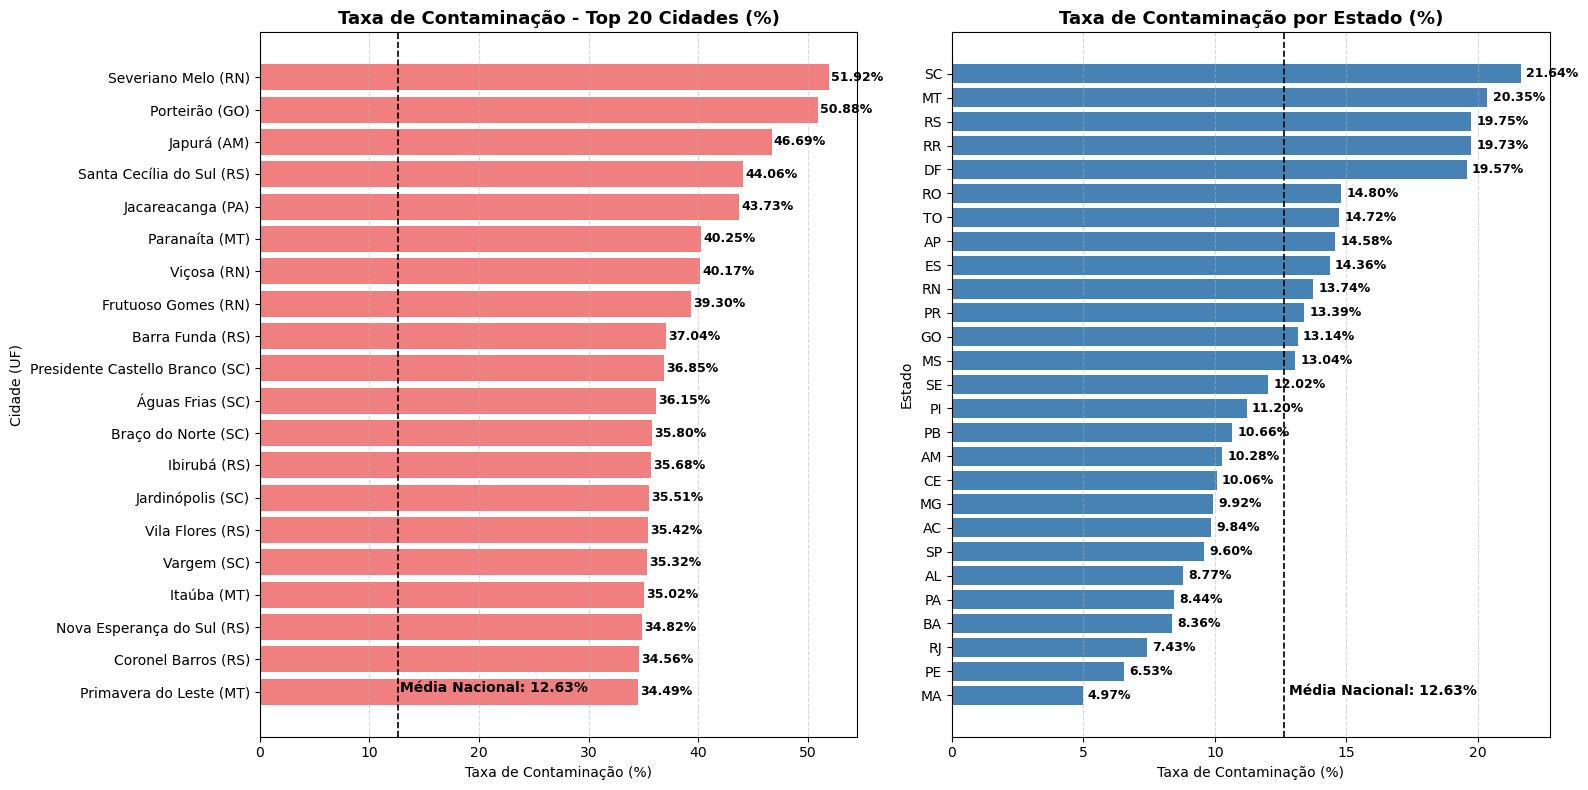

In [10]:
taxas_por_cidade = df_cidade_ultimo[['city', 'state', 'estimated_population',
                                     'last_available_confirmed', 'last_available_deaths']].copy()

taxas_por_cidade = taxas_por_cidade[
    (taxas_por_cidade['estimated_population'] > 0) &
    (taxas_por_cidade['last_available_confirmed'] > 0)
]

taxas_por_cidade['taxa_contaminacao'] = (
    (taxas_por_cidade['last_available_confirmed'] / taxas_por_cidade['estimated_population']) * 100
)
taxas_por_cidade['taxa_mortalidade'] = (
    (taxas_por_cidade['last_available_deaths'] / taxas_por_cidade['last_available_confirmed']) * 100
)

top_cidades = taxas_por_cidade.sort_values(by='taxa_contaminacao', ascending=False).head(20).copy()
top_cidades['cidade_estado'] = top_cidades['city'] + ' (' + top_cidades['state'] + ')'

taxas_por_estado = (
    taxas_por_cidade
    .groupby('state', as_index=False)
    .agg({
        'estimated_population': 'sum',
        'last_available_confirmed': 'sum',
        'last_available_deaths': 'sum'
    })
)

taxas_por_estado['taxa_contaminacao'] = (
    (taxas_por_estado['last_available_confirmed'] / taxas_por_estado['estimated_population']) * 100
)
taxas_por_estado['taxa_mortalidade'] = (
    (taxas_por_estado['last_available_deaths'] / taxas_por_estado['last_available_confirmed']) * 100
)

taxas_por_estado = taxas_por_estado.sort_values(by='taxa_contaminacao', ascending=False).reset_index(drop=True)

media_nacional = taxas_por_estado['taxa_contaminacao'].mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(top_cidades['cidade_estado'], top_cidades['taxa_contaminacao'], color='lightcoral')
axes[0].set_title('Taxa de Contaminação - Top 20 Cidades (%)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Taxa de Contaminação (%)')
axes[0].set_ylabel('Cidade (UF)')
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(top_cidades['taxa_contaminacao']):
    axes[0].text(v + 0.2, i, f'{v:.2f}%', va='center', fontsize=9, fontweight='bold')

axes[0].axvline(media_nacional, color='black', linestyle='--', linewidth=1.2)
axes[0].text(media_nacional + 0.2, len(top_cidades) - 1, f'Média Nacional: {media_nacional:.2f}%',
             fontsize=10, fontweight='bold', color='black')

axes[1].barh(taxas_por_estado['state'], taxas_por_estado['taxa_contaminacao'], color='steelblue')
axes[1].set_title('Taxa de Contaminação por Estado (%)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Taxa de Contaminação (%)')
axes[1].set_ylabel('Estado')
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(taxas_por_estado['taxa_contaminacao']):
    axes[1].text(v + 0.2, i, f'{v:.2f}%', va='center', fontsize=9, fontweight='bold')

axes[1].axvline(media_nacional, color='black', linestyle='--', linewidth=1.2)
axes[1].text(media_nacional + 0.2, len(taxas_por_estado) - 1, f'Média Nacional: {media_nacional:.2f}%',
             fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


##### Regiões

In [11]:
# Mapeamento de estados para regiões do Brasil
regioes = {
    'Norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Inverter o dicionário para mapeamento direto
mapa_regioes = {estado: regiao for regiao, estados in regioes.items() for estado in estados}
df_estado_nao_repete['region'] = df_estado_nao_repete['state'].map(mapa_regioes)
df_cidade_nao_repete['region'] = df_cidade_nao_repete['state'].map(mapa_regioes)
df_cidade_ultimo['region'] = df_cidade_ultimo['state'].map(mapa_regioes)


C:\Users\Matheus\AppData\Local\Temp\ipykernel_33200\3335269876.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_estado_nao_repete['region'] = df_estado_nao_repete['state'].map(mapa_regioes)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_33200\3335269876.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cidade_nao_repete['region'] = df_cidade_nao_repete['state'].map(mapa_regioes)
C:\Users\Matheus\AppData\Local\Temp\ipykernel_33200\3335269876.py:14: SettingWithCopyWarning: 
A value is trying to be

In [12]:
mortes_regiao = (
    df_estado_nao_repete.groupby('region')[['last_available_deaths', 'last_available_confirmed']]
    .max()
    .reset_index()
)

mortes_regiao['taxa_mortalidade'] = (
    mortes_regiao['last_available_deaths'] / mortes_regiao['last_available_confirmed'] * 100
)

taxas_regiao = (
    df_cidade_ultimo.groupby('region')
    .agg({
        'estimated_population': 'sum',
        'last_available_confirmed': 'sum',
        'last_available_deaths': 'sum'
    })
    .reset_index()
)

taxas_regiao['taxa_contaminacao'] = (
    taxas_regiao['last_available_confirmed'] / taxas_regiao['estimated_population'] * 100
)
taxas_regiao['taxa_mortalidade'] = (
    taxas_regiao['last_available_deaths'] / taxas_regiao['last_available_confirmed'] * 100
)



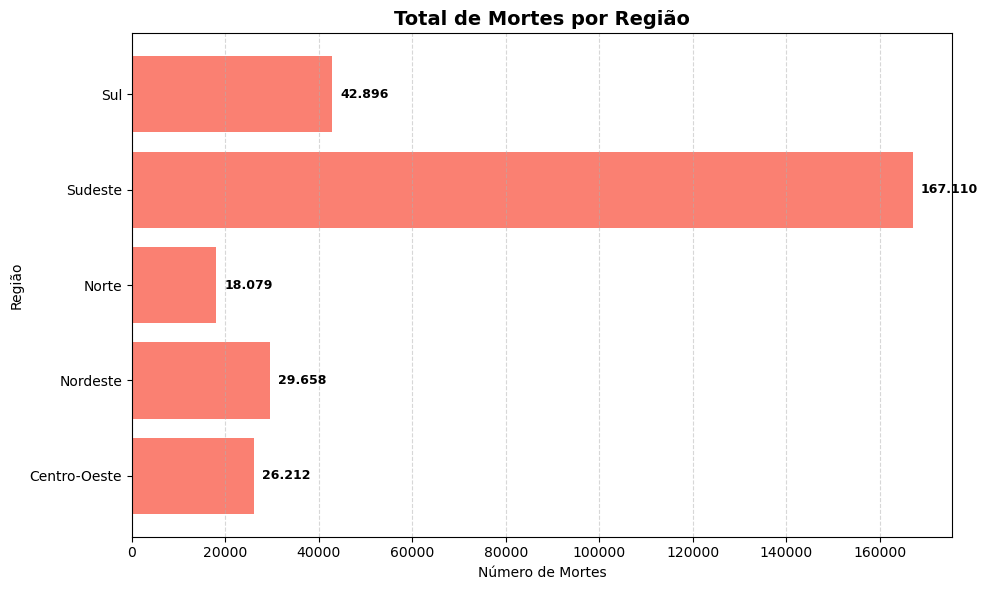

In [13]:
plt.figure(figsize=(10, 6))
bars = plt.barh(
    mortes_regiao['region'],
    mortes_regiao['last_available_deaths'],
    color='salmon'
)

plt.title('Total de Mortes por Região', fontsize=14, fontweight='bold')
plt.xlabel('Número de Mortes')
plt.ylabel('Região')
plt.grid(axis='x', linestyle='--', alpha=0.5)

for bar in bars:
    plt.text(
        bar.get_width() + mortes_regiao['last_available_deaths'].max() * 0.01,
        bar.get_y() + bar.get_height()/2,
        f'{int(bar.get_width()):,}'.replace(',', '.'),
        va='center', fontsize=9, fontweight='bold'
    )

plt.tight_layout()
plt.show()


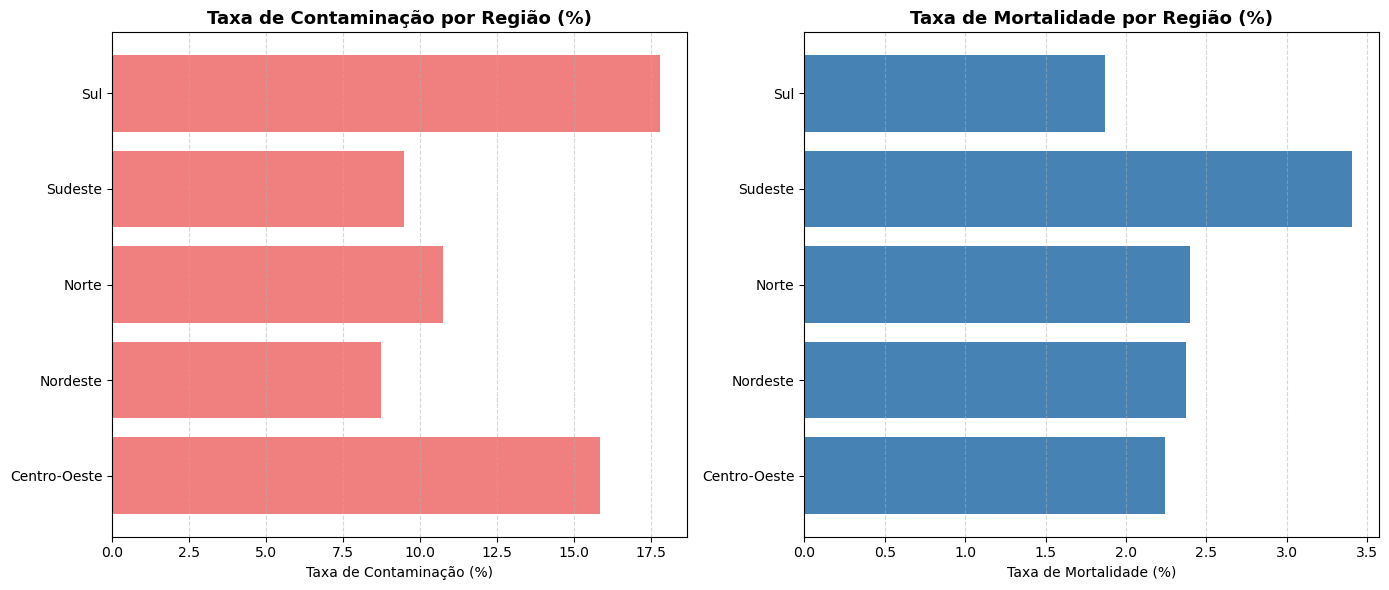

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Taxa de Contaminação ---
axes[0].barh(
    taxas_regiao['region'],
    taxas_regiao['taxa_contaminacao'],
    color='lightcoral'
)
axes[0].set_title('Taxa de Contaminação por Região (%)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Taxa de Contaminação (%)')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# --- Taxa de Mortalidade ---
axes[1].barh(
    taxas_regiao['region'],
    taxas_regiao['taxa_mortalidade'],
    color='steelblue'
)
axes[1].set_title('Taxa de Mortalidade por Região (%)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Taxa de Mortalidade (%)')
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


##### Análise cidades de SP

📍 O estado de SP possui 645 cidades com dados disponíveis.
🧠 Estatísticas da Taxa de Mortalidade em SP:
- Média estadual: 3.05%
- Desvio padrão: 1.42%
- Coeficiente de variação (CV): 46.69%


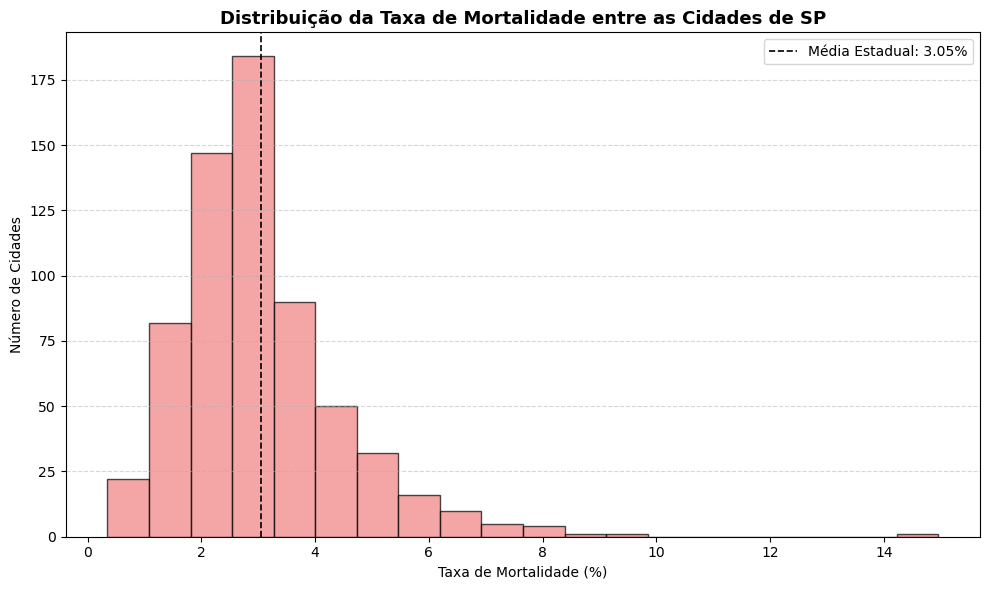

In [15]:
# Filtrar apenas cidades do estado de SP
df_sp = df_cidade_ultimo[df_cidade_ultimo['state'] == 'SP'].copy()

# Garantir que há valores válidos
df_sp = df_sp[df_sp['last_available_death_rate'].notna()]
df_sp['taxa_mortalidade'] = df_sp['last_available_death_rate'] * 100

# Total de cidades
n_cidades_sp = df_sp['city'].nunique()
print(f"📍 O estado de SP possui {n_cidades_sp} cidades com dados disponíveis.")

media_sp = df_sp['taxa_mortalidade'].mean()
desvio_sp = df_sp['taxa_mortalidade'].std()
cv_sp = (desvio_sp / media_sp) * 100

print(f"🧠 Estatísticas da Taxa de Mortalidade em SP:")
print(f"- Média estadual: {media_sp:.2f}%")
print(f"- Desvio padrão: {desvio_sp:.2f}%")
print(f"- Coeficiente de variação (CV): {cv_sp:.2f}%")

plt.figure(figsize=(10,6))
plt.hist(df_sp['taxa_mortalidade'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(media_sp, color='black', linestyle='--', linewidth=1.2, label=f'Média Estadual: {media_sp:.2f}%')
plt.title('Distribuição da Taxa de Mortalidade entre as Cidades de SP', fontsize=13, fontweight='bold')
plt.xlabel('Taxa de Mortalidade (%)')
plt.ylabel('Número de Cidades')
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



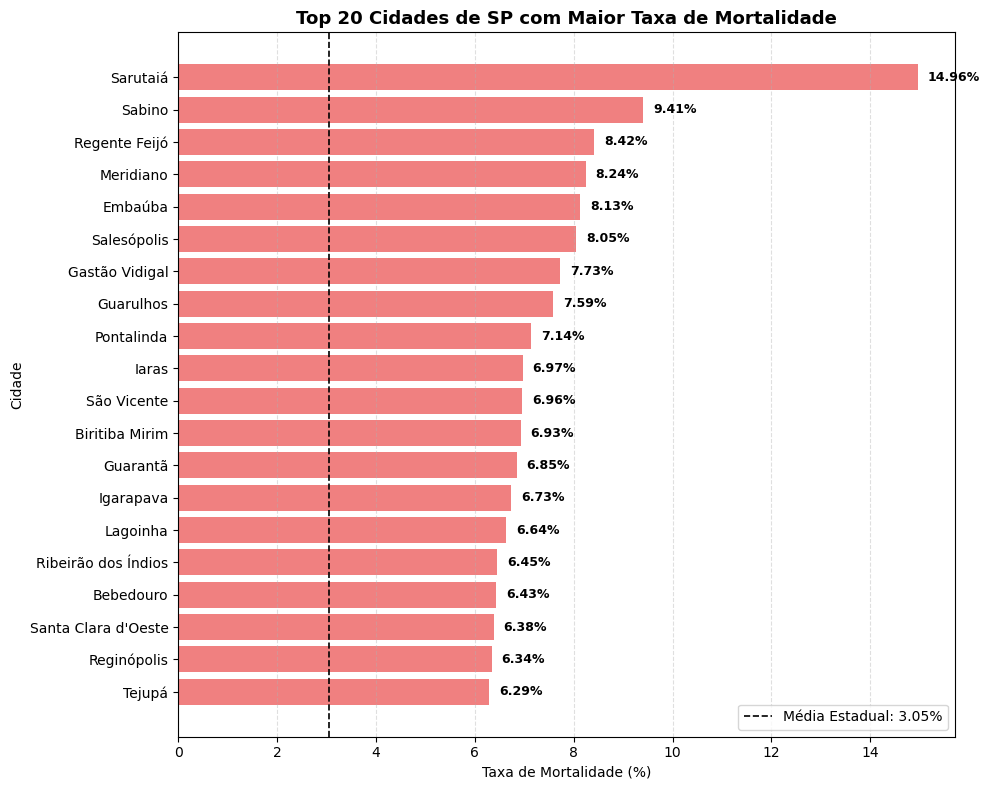

In [16]:
top20_sp = (
    df_sp[['city', 'taxa_mortalidade']]
    .sort_values(by='taxa_mortalidade', ascending=False)
    .head(20)
)

plt.figure(figsize=(10,8))
bars = plt.barh(top20_sp['city'], top20_sp['taxa_mortalidade'], color='lightcoral')
plt.axvline(media_sp, color='black', linestyle='--', linewidth=1.2, label=f'Média Estadual: {media_sp:.2f}%')
plt.title('Top 20 Cidades de SP com Maior Taxa de Mortalidade', fontsize=13, fontweight='bold')
plt.xlabel('Taxa de Mortalidade (%)')
plt.ylabel('Cidade')
plt.legend(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.gca().invert_yaxis()

for bar in bars:
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


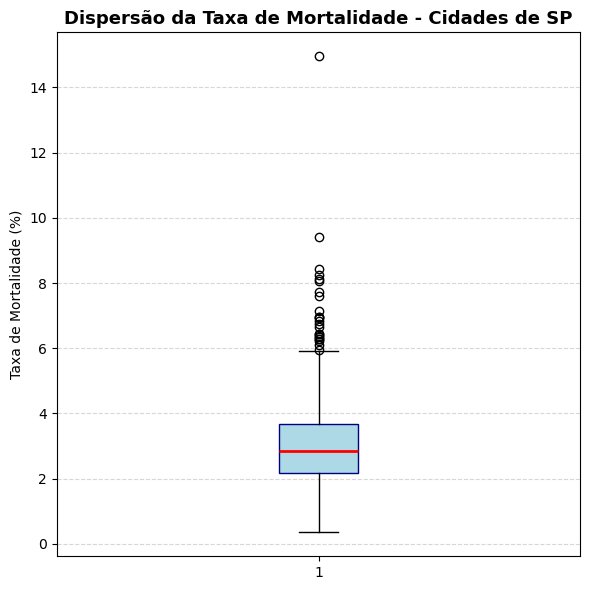

In [17]:
plt.figure(figsize=(6,6))
plt.boxplot(df_sp['taxa_mortalidade'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='navy'),
            medianprops=dict(color='red', linewidth=2))

plt.title('Dispersão da Taxa de Mortalidade - Cidades de SP', fontsize=13, fontweight='bold')
plt.ylabel('Taxa de Mortalidade (%)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##### Cidade SP x Interior

In [25]:
df_estado_ultimo

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
16149,NaN,12.0,2022-03-27,202213,894470.0,881935.0,True,False,123808,13841.49273,2022-03-27,0.0161,1992,741,state,AC,31,0
88165,NaN,27.0,2022-03-26,202212,3351543.0,3337357.0,True,False,295972,8830.91758,2022-03-26,0.0232,6869,749,state,AL,56,3
132889,NaN,13.0,2022-03-27,202213,4207714.0,4144597.0,True,False,581070,13809.63630,2022-03-27,0.0244,14151,745,state,AM,28,0
144950,NaN,16.0,2022-03-27,202213,861773.0,845731.0,True,False,160328,18604.43527,2022-03-27,0.0132,2122,738,state,AP,7,0
432708,NaN,29.0,2022-03-27,202213,14930634.0,14873064.0,True,False,1530054,10247.74969,2022-03-27,0.0194,29658,752,state,BA,1046,2
564442,NaN,23.0,2022-03-27,202213,9187103.0,9132078.0,True,False,1239746,13494.41712,2022-03-27,0.0215,26708,742,state,CE,44,9
566670,NaN,53.0,2022-03-25,202212,3055149.0,3015268.0,True,False,691353,22629.10909,2022-03-25,0.0167,11573,749,state,DF,339,4
623630,NaN,32.0,2022-03-27,202213,4064052.0,4018650.0,True,False,1037188,25521.03172,2022-03-27,0.0138,14323,753,state,ES,102,0
790659,NaN,52.0,2022-03-27,202213,7113540.0,7018354.0,True,False,1269853,17851.21051,2022-03-27,0.0206,26212,746,state,GO,170,4
942247,NaN,21.0,2022-03-27,202213,7114598.0,7075181.0,True,False,424199,5962.37482,2022-03-27,0.0256,10869,738,state,MA,63,1


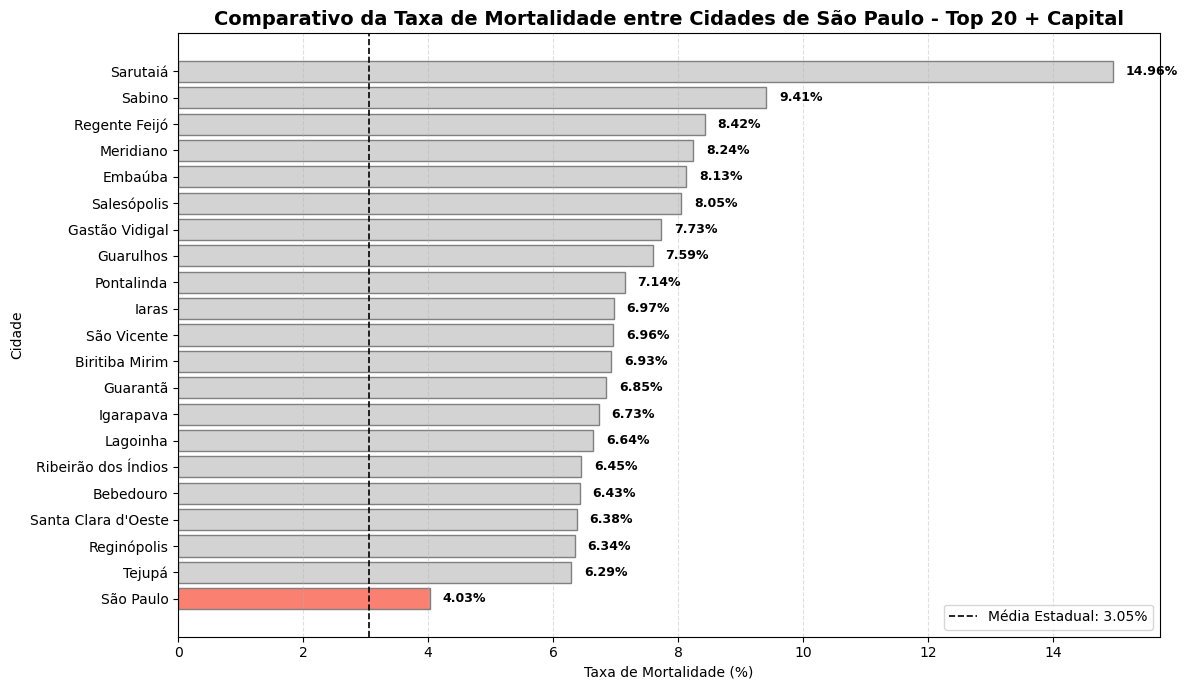

📍 A cidade de São Paulo possui taxa de mortalidade de 4.03%.
🏛️ A média estadual de SP é 3.05%.
➡️ A capital está acima da média estadual por aproximadamente 0.98 pontos percentuais.


In [28]:
df_sp = df_cidade_ultimo[df_cidade_ultimo['state'] == 'SP'].copy()
df_sp = df_sp[df_sp['last_available_death_rate'].notna()]
df_sp['taxa_mortalidade'] = df_sp['last_available_death_rate'] * 100

df_estado_sp = df_estado_ultimo[df_estado_ultimo['state'] == 'SP'].copy()
df_estado_sp['taxa_mortalidade'] = df_estado_sp['last_available_death_rate'] * 100

media_sp = df_sp['taxa_mortalidade'].mean()

cidade_alvo = 'São Paulo'

if cidade_alvo not in df_sp['city'].values:
    print("⚠️ Cidade de São Paulo não encontrada no dataset!")
else:
    valor_cidade = df_sp.loc[df_sp['city'] == cidade_alvo, 'taxa_mortalidade'].iloc[0]

df_sp = df_sp.sort_values(by='taxa_mortalidade', ascending=False).reset_index(drop=True)
top20 = df_sp.head(20)

if cidade_alvo not in top20['city'].values:
    linha_capital = df_sp[df_sp['city'] == cidade_alvo]
    top20 = pd.concat([top20, linha_capital], ignore_index=True)

plt.figure(figsize=(12, 7))

cores = ['salmon' if c == cidade_alvo else 'lightgray' for c in top20['city']]

plt.barh(top20['city'], top20['taxa_mortalidade'], color=cores, edgecolor='gray')

plt.axvline(media_sp, color='black', linestyle='--', linewidth=1.2, label=f'Média Estadual: {media_sp:.2f}%')

plt.title('Comparativo da Taxa de Mortalidade entre Cidades de São Paulo - Top 20 + Capital', fontsize=14, fontweight='bold')
plt.xlabel('Taxa de Mortalidade (%)')
plt.ylabel('Cidade')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.4)

for i, (cidade, valor) in enumerate(zip(top20['city'], top20['taxa_mortalidade'])):
    #if cidade == cidade_alvo or i < 5:
    plt.text(valor + 0.2, i, f'{valor:.2f}%', va='center', fontsize=9, fontweight='bold')

# Legenda
plt.legend(fontsize=10, loc='lower right')
plt.tight_layout()
plt.show()

relacao = "acima" if valor_cidade > media_sp else "abaixo"
dif = abs(valor_cidade - media_sp)

print(f"📍 A cidade de {cidade_alvo} possui taxa de mortalidade de {valor_cidade:.2f}%.")
print(f"🏛️ A média estadual de SP é {media_sp:.2f}%.")
print(f"➡️ A capital está {relacao} da média estadual por aproximadamente {dif:.2f} pontos percentuais.")


##### Maiores cidades de SP

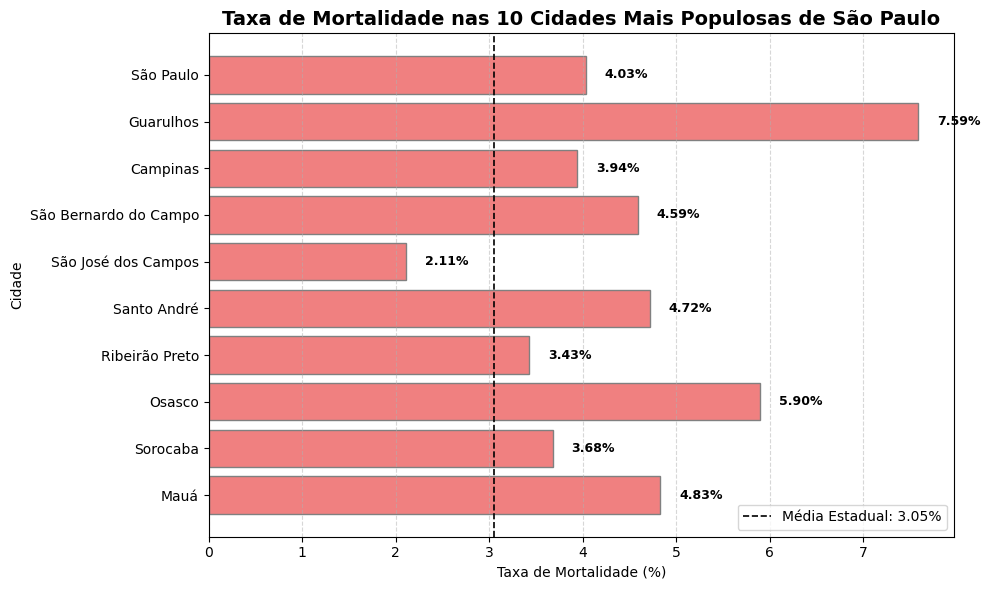

📊 Cidades mais populosas e suas taxas de mortalidade:
                 city  taxa_mortalidade
            São Paulo              4.03
            Guarulhos              7.59
             Campinas              3.94
São Bernardo do Campo              4.59
  São José dos Campos              2.11
          Santo André              4.72
       Ribeirão Preto              3.43
               Osasco              5.90
             Sorocaba              3.68
                 Mauá              4.83

🏛️ Média estadual: 3.05%

⬆️ 9 cidades acima da média estadual (São Paulo, Guarulhos, Campinas, São Bernardo do Campo, Santo André, Ribeirão Preto, Osasco, Sorocaba, Mauá)
⬇️ 1 cidades abaixo da média estadual (São José dos Campos)


In [19]:
df_populosas = (
    df_sp.sort_values(by='estimated_population_2019', ascending=False)
    .head(10)
    .loc[:, ['city', 'estimated_population_2019', 'taxa_mortalidade']]
    .reset_index(drop=True)
)

media_sp = df_sp['taxa_mortalidade'].mean()

plt.figure(figsize=(10, 6))
plt.barh(df_populosas['city'], df_populosas['taxa_mortalidade'], color='lightcoral', edgecolor='gray')
plt.axvline(media_sp, color='black', linestyle='--', linewidth=1.2, label=f'Média Estadual: {media_sp:.2f}%')

plt.title('Taxa de Mortalidade nas 10 Cidades Mais Populosas de São Paulo', fontsize=14, fontweight='bold')
plt.xlabel('Taxa de Mortalidade (%)')
plt.ylabel('Cidade')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, v in enumerate(df_populosas['taxa_mortalidade']):
    plt.text(v + 0.2, i, f'{v:.2f}%', va='center', fontsize=9, fontweight='bold')

plt.legend(fontsize=10, loc='lower right')
plt.tight_layout()
plt.show()

print("📊 Cidades mais populosas e suas taxas de mortalidade:")
print(df_populosas[['city', 'taxa_mortalidade']].to_string(index=False))

print(f"\n🏛️ Média estadual: {media_sp:.2f}%")

acima = df_populosas[df_populosas['taxa_mortalidade'] > media_sp]
abaixo = df_populosas[df_populosas['taxa_mortalidade'] <= media_sp]

print(f"\n⬆️ {len(acima)} cidades acima da média estadual ({', '.join(acima['city'])})")
print(f"⬇️ {len(abaixo)} cidades abaixo da média estadual ({', '.join(abaixo['city'])})")

##### Regressão linear

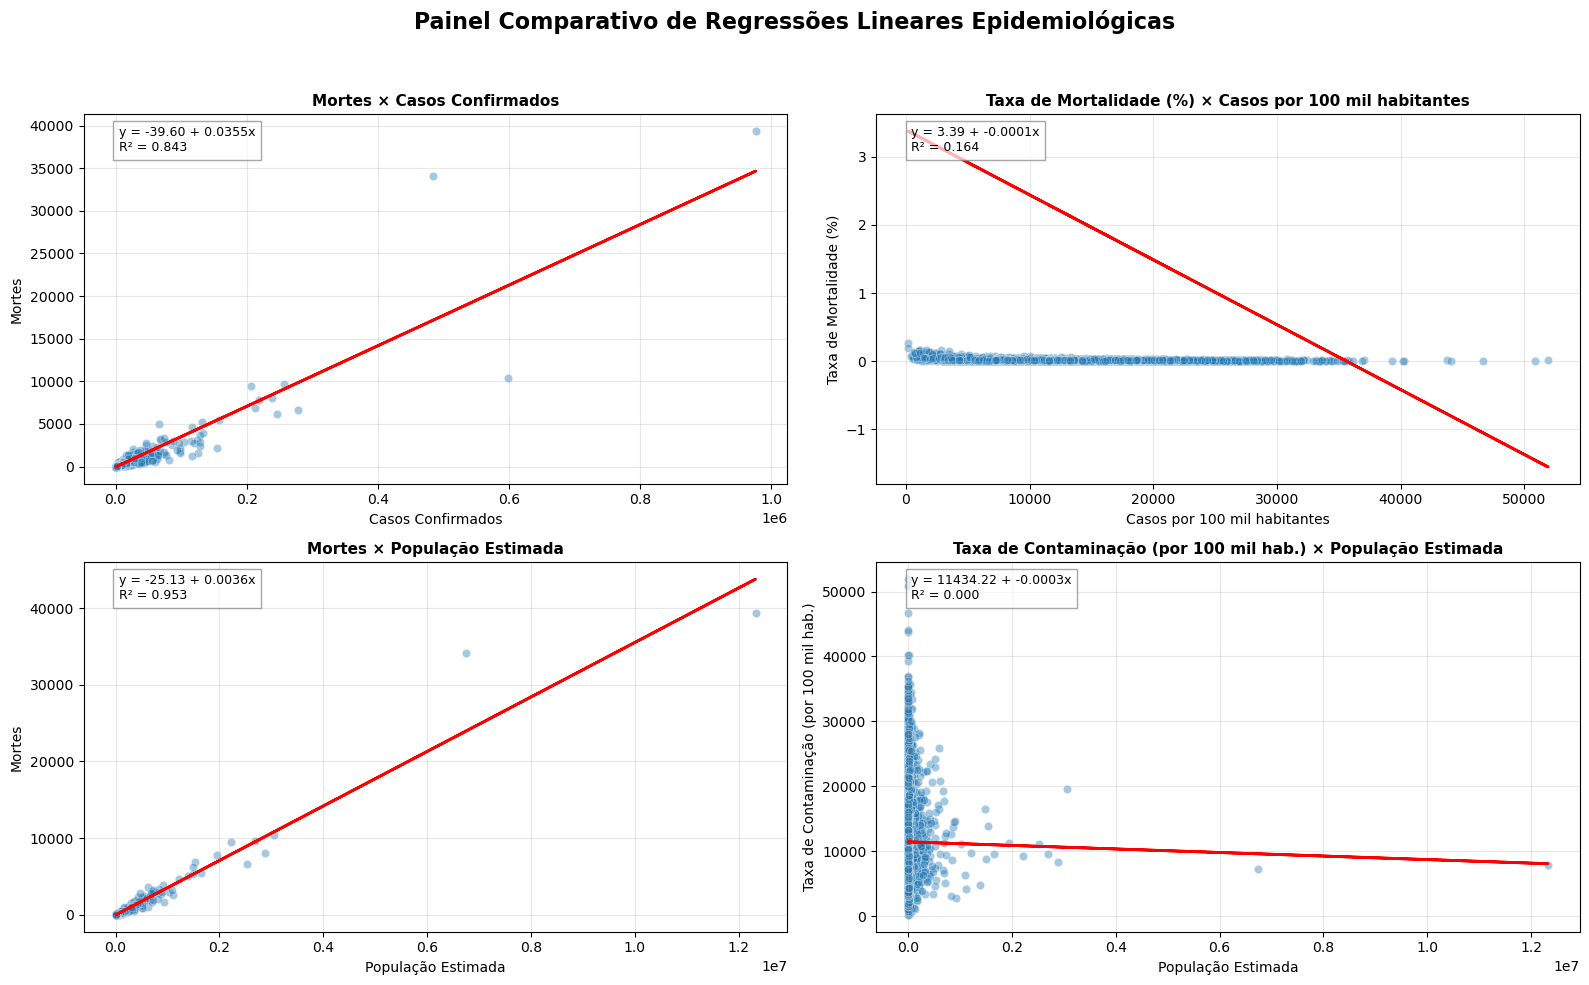

In [20]:
df_reg = df_cidade_ultimo.copy()
df_reg = df_reg[
    (df_reg['last_available_confirmed'] > 0) &
    (df_reg['last_available_deaths'] > 0) &
    (df_reg['estimated_population'] > 0)
]


variaveis = [
    ("last_available_confirmed", "last_available_deaths", "Casos Confirmados", "Mortes"),
    ("last_available_confirmed_per_100k_inhabitants", "last_available_death_rate", "Casos por 100 mil habitantes", "Taxa de Mortalidade (%)"),
    ("estimated_population", "last_available_deaths", "População Estimada", "Mortes"),
    ("estimated_population", "last_available_confirmed_per_100k_inhabitants", "População Estimada", "Taxa de Contaminação (por 100 mil hab.)")
]


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.suptitle('Painel Comparativo de Regressões Lineares Epidemiológicas', fontsize=16, fontweight='bold')

for i, (x_col, y_col, x_label, y_label) in enumerate(variaveis):
    ax = axes[i // 2, i % 2]

    X = df_reg[[x_col]].values
    y = df_reg[y_col].values * (100 if 'rate' in y_col else 1)

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = model.score(X, y)
    b0, b1 = model.intercept_, model.coef_[0]

    sns.scatterplot(x=x_col, y=y_col, data=df_reg, ax=ax, alpha=0.4)
    ax.plot(X, y_pred, color='red', linewidth=2)

    # Títulos e rótulos
    ax.set_title(f"{y_label} × {x_label}", fontsize=11, fontweight='bold')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(alpha=0.3)

    # Texto da equação e R²
    eq_text = f"y = {b0:.2f} + {b1:.4f}x\nR² = {r2:.3f}"
    ax.text(0.05, 0.90, eq_text, transform=ax.transAxes,
            fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

| Relação                                        | R²    | Interpretação                                                                                                                                                                                                                                                                                                                                                 |
| ---------------------------------------------- | ----- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Mortes × Casos Confirmados**                 | 0.843 | Forte correlação linear. A quantidade de mortes cresce quase proporcionalmente ao número de casos confirmados. Isso confirma a coerência epidemiológica — o aumento de infecções está diretamente ligado ao aumento de óbitos.                                                                                                                                |
| **Taxa de Mortalidade × Taxa de Contaminação** | 0.164 | Correlação fraca e **inversa**. Regiões com mais contaminação não necessariamente apresentam maior mortalidade, o que sugere influência de outros fatores, como infraestrutura hospitalar, disponibilidade de leitos, capacidade de testagem e idade média populacional.                                                                                      |
| **Mortes × População**                         | 0.953 | Correlação **muito forte e positiva**. Cidades mais populosas concentram maior número absoluto de mortes, o que é esperado, já que o volume populacional é o principal determinante do total de óbitos, mas não reflete risco proporcional maior — apenas maior número absoluto de habitantes expostos.                                                       |
| **Taxa de Contaminação × População**           | 0.000 | Correlação **nula e ligeiramente negativa**. Isso indica que o tamanho populacional **não explica a taxa proporcional de contaminação** — cidades grandes e pequenas apresentaram proporções semelhantes, o que pode refletir **heterogeneidade de testagem e notificação**, bem como **diferenças locais na velocidade de propagação e controle da doença.** |



In [21]:
taxas_regiao = (
    df_cidade_ultimo.groupby("region").agg({
        "estimated_population":"sum",
        "last_available_confirmed":"sum",
        "last_available_deaths":"sum"
    }).reset_index()
)
taxas_regiao["taxa_contaminacao"] = taxas_regiao["last_available_confirmed"] / taxas_regiao["estimated_population"] * 100
taxas_regiao["taxa_mortalidade"] = taxas_regiao["last_available_deaths"] / taxas_regiao["last_available_confirmed"] * 100

In [22]:
taxas_regiao.sort_values(by='taxa_contaminacao', ascending=False)

,region,estimated_population,last_available_confirmed,last_available_deaths,taxa_contaminacao,taxa_mortalidade
4,Sul,30192315.0,5367944,100215,17.779173,1.866916
0,Centro-Oeste,16504303.0,2616826,58708,15.855417,2.243481
2,Norte,18672591.0,2003984,48108,10.732222,2.400618
3,Sudeste,89012240.0,8430197,286919,9.470829,3.403467
1,Nordeste,57374243.0,5010880,119017,8.733675,2.375172
